<a href="https://colab.research.google.com/github/UzunDemir/uzundemir.github.io/blob/master/notebooks/afr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация правил для антифродовой системы с использованием ML

https://github.com/user-attachments/assets/58469d03-7de1-465f-b67b-d020d8189480

## Шаг 1: Импорт необходимых библиотек

In [1]:
#!pip install pyarrow


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import graphviz
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler

## Шаг 2: Инициализация Spark и загрузка данных

In [3]:
import zipfile

# Путь к архиву
zip_path = "/content/drive/MyDrive/fraud_data/fraud_detection_dataset_1.zip"

# Путь для извлечения
extract_to = "/content/fraud_data"

# Извлечение файлов
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Файлы успешно извлечены в {extract_to}")


Файлы успешно извлечены в /content/fraud_data


In [4]:
# Инициализация SparkSession (если ещё не инициализирована)
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Load Parquet File") \
    .getOrCreate()

# Загрузка Parquet-файла
parquet_path = "/content/fraud_data/fraud_detection_dataset_1.parquet"
df = spark.read.parquet(parquet_path)

# Отображение схемы и первых строк
df.printSchema()
df.show(5)


root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_foreign: integer (nullable = true)
 |-- is_online: integer (nullable = true)
 |-- is_night: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- operating_system: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- amount_deviation: doub

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# Импорт Spark
from pyspark.sql import SparkSession

# # Инициализация Spark-сессии
# spark = SparkSession.builder \
#     .appName("FraudDetectionRules") \
#     .config("spark.driver.memory", "8g") \
#     .getOrCreate()

# Пути к данным
base_path = "/content/drive/MyDrive/fraud_data/"
transactions_path = base_path + "fraud_detection_dataset.parquet"
customers_path = base_path + "customer_data.parquet"
merchants_path = base_path + "merchant_data.parquet"

# Загрузка данных
#df_transactions = spark.read.parquet(transactions_path)
df_customers = spark.read.parquet(customers_path)
df_merchants = spark.read.parquet(merchants_path)

# Просмотр схемы и примеров
#df_transactions.printSchema()
#df_transactions.show(5)
df_customers.printSchema()
df_customers.show(5)

root
 |-- customer_id: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: long (nullable = true)
 |-- credit_score: long (nullable = true)
 |-- registration_date: date (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- avg_transaction_amount: long (nullable = true)
 |-- transaction_frequency: long (nullable = true)

+-----------+---+------+------------+-----------------+---------+-------+-----------+----------------------+---------------------+
|customer_id|age|income|credit_score|registration_date|is_active|country|device_type|avg_transaction_amount|transaction_frequency|
+-----------+---+------+------------+-----------------+---------+-------+-----------+----------------------+---------------------+
|    C000000| 56| 48578|         683|       2023-07-06|     true|     MX|     mobile|                    41|                    4|
|    C000001| 69| 18560|         740|     

In [6]:
df_merchants.printSchema()

root
 |-- merchant_id: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- risk_score: double (nullable = true)



In [7]:
from pyspark.sql.functions import col

# Получим список колонок, которые уже есть в df
df_cols = set(df.columns)

# Выберем только новые столбцы из df_customers
df_customers_new_cols = [col(c) for c in df_customers.columns if c not in df_cols and c != 'customer_id']
df_customers_trimmed = df_customers.select('customer_id', *df_customers_new_cols)

# Джойним по customer_id
df = df.join(df_customers_trimmed, on='customer_id', how='left')

# Обновим список колонок и сделаем то же самое с df_merchants
df_cols = set(df.columns)
df_merchants_new_cols = [col(c) for c in df_merchants.columns if c not in df_cols and c != 'merchant_id']
df_merchants_trimmed = df_merchants.select('merchant_id', *df_merchants_new_cols)

# Джойним по merchant_id
df = df.join(df_merchants_trimmed, on='merchant_id', how='left')

# Посмотрим итоговую схему
df.printSchema()


root
 |-- merchant_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_foreign: integer (nullable = true)
 |-- is_online: integer (nullable = true)
 |-- is_night: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- operating_system: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- amount_deviation: doub

## Признаки
---

### **Основная информация о транзакции:**

- **`transaction_id`** – уникальный идентификатор транзакции.  
- **`customer_id`** – уникальный идентификатор клиента.  
- **`merchant_id`** – уникальный идентификатор торговой точки или продавца.  
- **`timestamp`** – точное время совершения транзакции.  
- **`date`** – дата транзакции (может быть выделена отдельно из `timestamp`).  
- **`amount`** – сумма транзакции.  
- **`currency`** – валюта транзакции (например, USD, EUR).  
- **`is_fraud`** – метка, является ли транзакция мошеннической (1 — да, 0 — нет).  

---

### **Контекст транзакции:**

- **`is_foreign`** – признак, была ли транзакция международной (за пределами страны клиента).  
- **`is_online`** – признак, была ли транзакция онлайн.  
- **`is_night`** – признак, была ли транзакция совершена ночью.  
- **`is_weekend`** – признак, была ли транзакция в выходной день.  
- **`hour`** – час суток, когда была совершена транзакция.  
- **`day_of_week`** – день недели (0 — понедельник, 6 — воскресенье).  

---

### **Техническая информация:**

- **`ip_address`** – IP-адрес, с которого была совершена транзакция.  
- **`device_id`** – идентификатор устройства, с которого была совершена транзакция.  
- **`operating_system`** – операционная система устройства (например, iOS, Android, Windows).  

---

### **Профиль клиента:**

- **`age`** – возраст клиента.  
- **`income`** – уровень дохода клиента.  
- **`credit_score`** – кредитный рейтинг клиента.  

---

### **Профиль торговой точки:**

- **`merchant_category`** – категория торговой точки (например, рестораны, электроника).  
- **`risk_score`** – оценка риска торговой точки (чем выше, тем подозрительнее).  
- **`merchant_country`** – страна, в которой зарегистрирован продавец.  

---

### **Аналитические признаки:**

- **`amount_deviation`** – отклонение суммы транзакции от среднего значения для клиента.  
- **`time_since_last_tx`** – время, прошедшее с последней транзакции этого клиента.  

---

### **Правила фрод-детекции (rule-based):**

- **`rule_high_amount_night`** – признак срабатывания правила: высокая сумма ночью.  
- **`rule_foreign_new_device`** – правило: иностранная транзакция с нового устройства.  
- **`rule_high_risk_merchant`** – правило: транзакция у продавца с высоким риском.  
- **`rule_fast_sequence`** – правило: слишком быстрые транзакции подряд.  
- **`rule_country_change`** – правило: смена страны клиента по сравнению с предыдущей транзакцией.

---


In [8]:
df.show(10)

+-----------+-----------+--------------+--------------------+----------+------------------+--------+--------+----------+---------+--------+----------+------------------+-----------+---------------+--------------------+----------------+---+------+------------+-----------------+------------------+----------------+--------------------+------------------+----------------------+-----------------------+-----------------------+------------------+-------------------+-----------------+---------+-------+-----------+----------------------+---------------------+--------------------+
|merchant_id|customer_id|transaction_id|           timestamp|      date|            amount|currency|is_fraud|is_foreign|is_online|is_night|is_weekend|              hour|day_of_week|     ip_address|           device_id|operating_system|age|income|credit_score|merchant_category|        risk_score|merchant_country|    amount_deviation|time_since_last_tx|rule_high_amount_night|rule_foreign_new_device|rule_high_risk_merchan

In [9]:
# Количество строк (наблюдений)
num_rows = df.count()

# Количество признаков (столбцов)
num_columns = len(df.columns)

# Имя целевого признака
target_column = 'is_fraud'

# Выводим информацию
print(f"Количество строк: {num_rows}")
print(f"Количество признаков: {num_columns}")
print(f"Целевая переменная: '{target_column}'")


Количество строк: 2000000
Количество признаков: 37
Целевая переменная: 'is_fraud'


In [10]:
df.groupBy('is_fraud').count().show()


+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|  10000|
|       0|1990000|
+--------+-------+



In [11]:
df.printSchema()

root
 |-- merchant_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_foreign: integer (nullable = true)
 |-- is_online: integer (nullable = true)
 |-- is_night: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- operating_system: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- amount_deviation: doub

### 🔍 Проверим пропущенные значения

In [12]:
from pyspark.sql.functions import col, sum as spark_sum

df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-----------+-----------+--------------+---------+----+------+--------+--------+----------+---------+--------+----------+----+-----------+----------+---------+----------------+---+------+------------+-----------------+----------+----------------+----------------+------------------+----------------------+-----------------------+-----------------------+------------------+-------------------+-----------------+---------+-------+-----------+----------------------+---------------------+-------------+
|merchant_id|customer_id|transaction_id|timestamp|date|amount|currency|is_fraud|is_foreign|is_online|is_night|is_weekend|hour|day_of_week|ip_address|device_id|operating_system|age|income|credit_score|merchant_category|risk_score|merchant_country|amount_deviation|time_since_last_tx|rule_high_amount_night|rule_foreign_new_device|rule_high_risk_merchant|rule_fast_sequence|rule_country_change|registration_date|is_active|country|device_type|avg_transaction_amount|transaction_frequency|merchant_name|


### 📈 Статистики по числовым признакам

In [13]:
df.describe().show()


+-------+-----------+-----------+--------------+-------------------+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+----------------+------------------+------------------+-----------------+-----------------+------------------+----------------+-------------------+------------------+----------------------+-----------------------+-----------------------+-------------------+-------------------+-------+-----------+----------------------+---------------------+-------------+
|summary|merchant_id|customer_id|transaction_id|             amount|currency|           is_fraud|         is_foreign|         is_online|          is_night|        is_weekend|              hour|       day_of_week|  ip_address|           device_id|operating_system|               age|            income|     credit_score|merchant_category|        risk_score|merchant_country|   amount_deviation|time

## 🔎 EDA (Exploratory Data Analysis)

### ✅ Шаг 1: Распределение целевой переменной

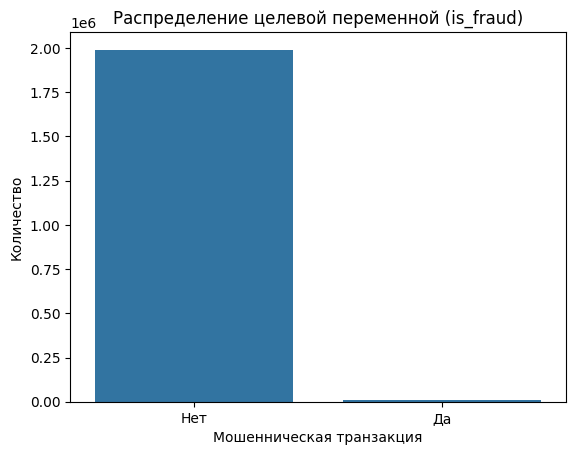

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_df = df.select("is_fraud").toPandas()

sns.countplot(x="is_fraud", data=fraud_df)
plt.title("Распределение целевой переменной (is_fraud)")
plt.xlabel("Мошенническая транзакция")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Нет', 'Да'])
plt.show()


### ✅ Шаг 2: Распределение по amount (сумма транзакции)

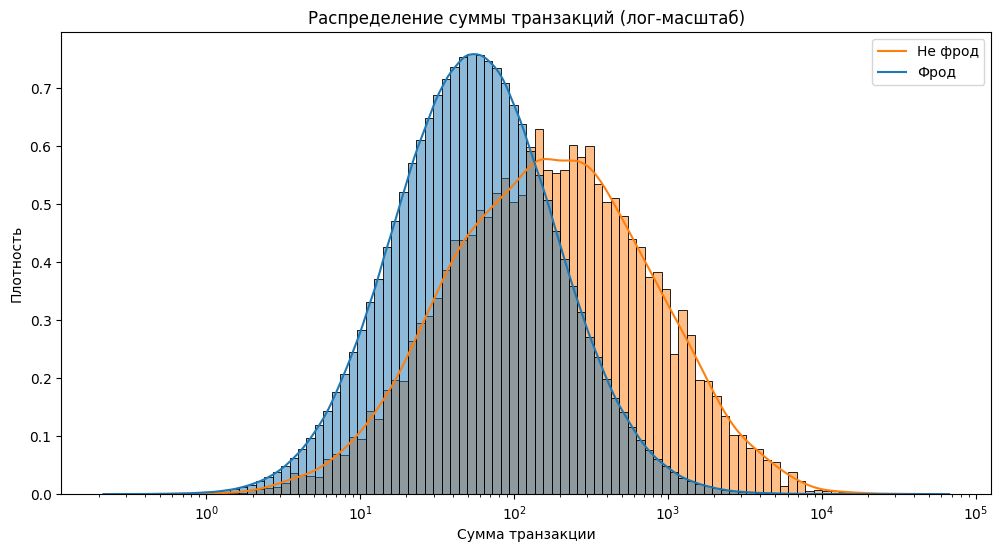

In [15]:
amount_df = df.select("amount", "is_fraud").toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(data=amount_df, x="amount", hue="is_fraud", bins=100, log_scale=(True, False), kde=True, stat="density", common_norm=False)
plt.title("Распределение суммы транзакций (лог-масштаб)")
plt.xlabel("Сумма транзакции")
plt.ylabel("Плотность")
plt.legend(["Не фрод", "Фрод"])
plt.show()


### ✅ Шаг 3: Категориальные переменные vs Фрод

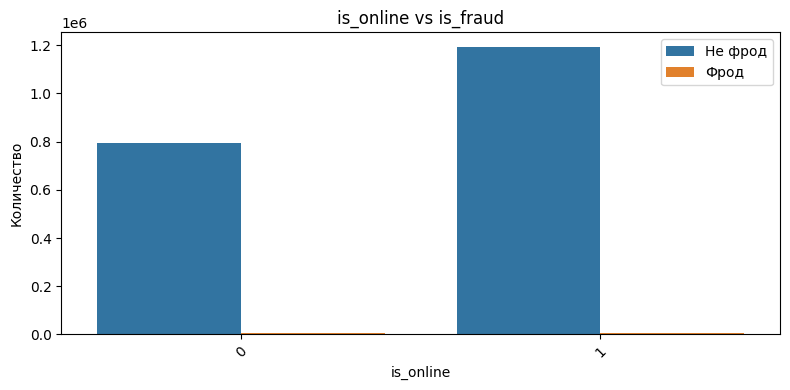

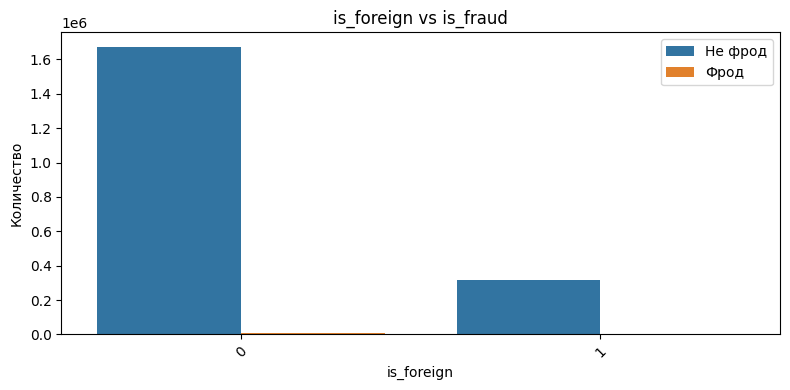

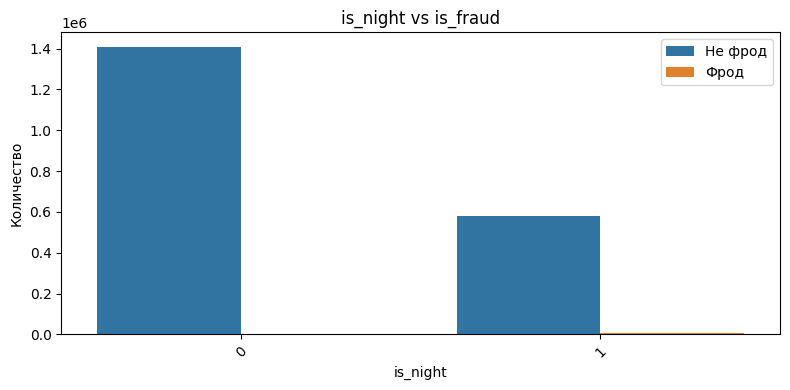

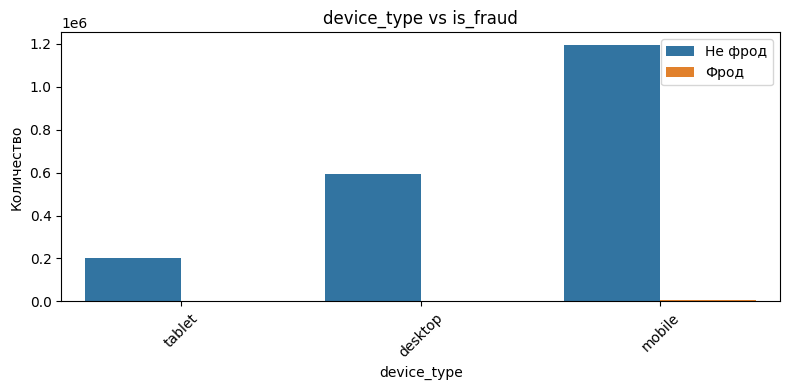

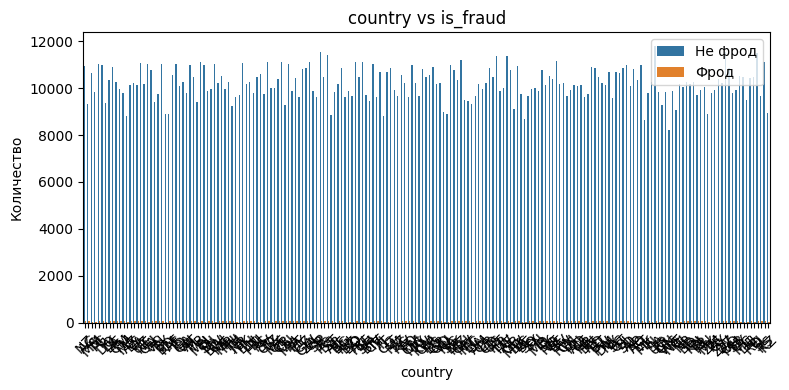

In [16]:
categorical_cols = ["is_online", "is_foreign", "is_night", "device_type", "country"]

for col in categorical_cols:
    temp_df = df.select(col, "is_fraud").toPandas()
    plt.figure(figsize=(8, 4))
    sns.countplot(data=temp_df, x=col, hue="is_fraud")
    plt.title(f"{col} vs is_fraud")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.legend(["Не фрод", "Фрод"])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### ✅ Шаг 4: Влияние времени

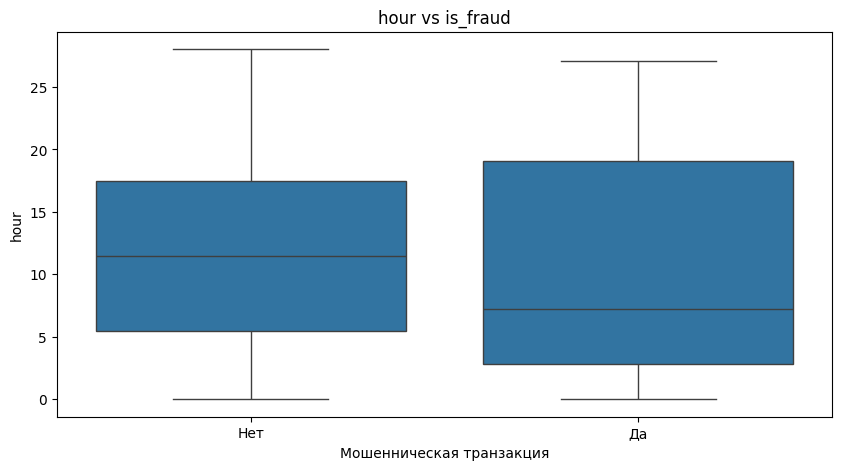

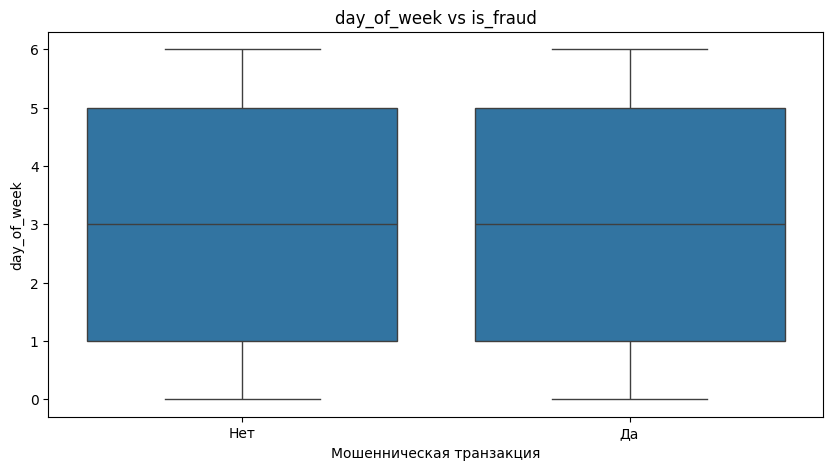

In [17]:
time_cols = ["hour", "day_of_week"]

for col in time_cols:
    temp_df = df.select(col, "is_fraud").toPandas()
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=temp_df, x="is_fraud", y=col)
    plt.title(f"{col} vs is_fraud")
    plt.xlabel("Мошенническая транзакция")
    plt.ylabel(col)
    plt.xticks([0, 1], ['Нет', 'Да'])
    plt.show()


In [18]:
from pyspark.sql.functions import col, isnan, count

df.select('currency') \
  .groupBy('currency') \
  .count() \
  .orderBy('currency') \
  .show(50, truncate=False)


+--------+-------+
|currency|count  |
+--------+-------+
|EUR     |599909 |
|GBP     |399899 |
|USD     |1000192|
+--------+-------+



In [19]:
from pyspark.sql.functions import col, count, when, isnan, lower

df.select(
    count(when(col('amount').isNull(), True)).alias('null'),
    count(when(isnan(col('amount')), True)).alias('NaN'),
    count(when(col('amount') == 0, True)).alias('Zero'),
    count(when(col('amount') == '', True)).alias('Empty string'),
    count(when(lower(col('amount').cast("string")) == 'null', True)).alias("String 'null'"),
    count(when(lower(col('amount').cast("string")) == 'nan', True)).alias("String 'nan'"),
    count(when(lower(col('amount').cast("string")) == 'none', True)).alias("String 'none'")
).show()


+----+---+----+------------+-------------+------------+-------------+
|null|NaN|Zero|Empty string|String 'null'|String 'nan'|String 'none'|
+----+---+----+------------+-------------+------------+-------------+
|   0|  0|   0|           0|            0|           0|            0|
+----+---+----+------------+-------------+------------+-------------+



In [20]:
from pyspark.sql.functions import col

# Получим все строковые столбцы
string_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() == 'string']

# Для каждого столбца выводим распределение значений
for col_name in string_cols:
    print(f"\n🔹 Распределение значений в колонке: {col_name}")
    df.groupBy(col(col_name)).count().orderBy(col(col_name)).show(50, truncate=False)



🔹 Распределение значений в колонке: merchant_id
+-----------+-----+
|merchant_id|count|
+-----------+-----+
|M000000    |224  |
|M000001    |193  |
|M000002    |193  |
|M000003    |179  |
|M000004    |190  |
|M000005    |189  |
|M000006    |221  |
|M000007    |210  |
|M000008    |217  |
|M000009    |223  |
|M000010    |202  |
|M000011    |189  |
|M000012    |168  |
|M000013    |184  |
|M000014    |210  |
|M000015    |177  |
|M000016    |192  |
|M000017    |208  |
|M000018    |184  |
|M000019    |191  |
|M000020    |185  |
|M000021    |171  |
|M000022    |187  |
|M000023    |207  |
|M000024    |217  |
|M000025    |219  |
|M000026    |183  |
|M000027    |209  |
|M000028    |191  |
|M000029    |205  |
|M000030    |200  |
|M000031    |229  |
|M000032    |198  |
|M000033    |199  |
|M000034    |202  |
|M000035    |200  |
|M000036    |214  |
|M000037    |209  |
|M000038    |204  |
|M000039    |205  |
|M000040    |188  |
|M000041    |192  |
|M000042    |209  |
|M000043    |186  |
|M000044   

In [21]:
# Например, для логических и категориальных числовых столбцов:
int_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ['int', 'boolean']]

for col_name in int_cols:
    print(f"\n🔹 Распределение значений в колонке: {col_name}")
    df.groupBy(col(col_name)).count().orderBy(col(col_name)).show()



🔹 Распределение значений в колонке: is_fraud
+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1990000|
|       1|  10000|
+--------+-------+


🔹 Распределение значений в колонке: is_foreign
+----------+-------+
|is_foreign|  count|
+----------+-------+
|         0|1680122|
|         1| 319878|
+----------+-------+


🔹 Распределение значений в колонке: is_online
+---------+-------+
|is_online|  count|
+---------+-------+
|        0| 799932|
|        1|1200068|
+---------+-------+


🔹 Распределение значений в колонке: is_night
+--------+-------+
|is_night|  count|
+--------+-------+
|       0|1412365|
|       1| 587635|
+--------+-------+


🔹 Распределение значений в колонке: is_weekend
+----------+-------+
|is_weekend|  count|
+----------+-------+
|         0|1442064|
|         1| 557936|
+----------+-------+


🔹 Распределение значений в колонке: day_of_week
+-----------+------+
|day_of_week| count|
+-----------+------+
|          0|300758|
|          1|299766|
|     

In [22]:
from pyspark.sql.functions import col

# Фильтруем NULL, группируем по ip_address и считаем количество
ip_counts = df.filter(col("operating_system").isNotNull()) \
              .groupBy("operating_system") \
              .count() \
              .orderBy("count", ascending=False)

# Показываем топ-N самых частых IP-адресов
ip_counts.show(20, truncate=False)

+----------------+------+
|operating_system|count |
+----------------+------+
|Android         |600459|
|iOS             |600046|
|Windows         |399743|
|MacOS           |199551|
+----------------+------+



In [23]:
df_result = df.drop("ip_address")


In [24]:
count_fraud_null = df.filter(col("operating_system").isNull() & (col("is_fraud") == True)).count()

print(f"Количество таких строк: {count_fraud_null}")


Количество таких строк: 1016


In [25]:
df = df.fillna({"operating_system": "Unknown"})


In [26]:
from pyspark.sql.functions import col

# Фильтруем NULL, группируем по ip_address и считаем количество
ip_counts = df.filter(col("operating_system").isNotNull()) \
              .groupBy("operating_system") \
              .count() \
              .orderBy("count", ascending=False)

# Показываем топ-N самых частых IP-адресов
ip_counts.show(20, truncate=False)

+----------------+------+
|operating_system|count |
+----------------+------+
|Android         |600459|
|iOS             |600046|
|Windows         |399743|
|Unknown         |200201|
|MacOS           |199551|
+----------------+------+



In [27]:
count_fraud_null = df.filter(col("device_id").isNull() & (col("is_fraud") == True)).count()

print(f"Количество таких строк: {count_fraud_null}")


Количество таких строк: 4993


In [28]:
df_result = df.drop("ip_address", "device_id")

In [29]:
df_result.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_result.columns]).show()


+-----------+-----------+--------------+---------+----+------+--------+--------+----------+---------+--------+----------+----+-----------+----------------+---+------+------------+-----------------+----------+----------------+----------------+------------------+----------------------+-----------------------+-----------------------+------------------+-------------------+-----------------+---------+-------+-----------+----------------------+---------------------+-------------+
|merchant_id|customer_id|transaction_id|timestamp|date|amount|currency|is_fraud|is_foreign|is_online|is_night|is_weekend|hour|day_of_week|operating_system|age|income|credit_score|merchant_category|risk_score|merchant_country|amount_deviation|time_since_last_tx|rule_high_amount_night|rule_foreign_new_device|rule_high_risk_merchant|rule_fast_sequence|rule_country_change|registration_date|is_active|country|device_type|avg_transaction_amount|transaction_frequency|merchant_name|
+-----------+-----------+--------------+--

In [30]:
df_result.printSchema()

root
 |-- merchant_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_foreign: integer (nullable = true)
 |-- is_online: integer (nullable = true)
 |-- is_night: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- operating_system: string (nullable = false)
 |-- age: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- amount_deviation: double (nullable = true)
 |-- time_since_last_tx: double (nullable = true)
 |-- rule_h

### Преобразование категориальных признаков в числовые

In [31]:
from pyspark.ml.feature import StringIndexer

# Индексация категориальных признаков
categorical_columns = ['merchant_id', 'currency', 'merchant_category', 'merchant_country', 'country', 'device_type', 'merchant_name', 'operating_system']

for column in categorical_columns:
    # Удаляем уже существующую колонку, если она есть
    if column + "_index" in df_result.columns:
        df_result = df_result.drop(column + "_index")

    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    df_result = indexer.fit(df_result).transform(df_result)



### Обработка бинарных признаков

In [32]:
# Проверяем, что бинарные признаки представлены как 0 и 1
binary_columns = ['is_fraud', 'is_foreign', 'is_online', 'is_night', 'is_weekend', 'rule_high_amount_night',
                  'rule_foreign_new_device', 'rule_high_risk_merchant', 'rule_fast_sequence', 'rule_country_change']
for column in binary_columns:
    df_result = df_result.withColumn(column, col(column).cast("integer"))


### Масштабирование числовых признаков

In [33]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

# Выбираем числовые признаки
numerical_columns = ['amount', 'age', 'income', 'credit_score', 'risk_score', 'amount_deviation', 'time_since_last_tx']

# Создаем вектор для масштабирования
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
df_result = assembler.transform(df_result)

# Масштабируем данные
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_result)
df_result = scaler_model.transform(df_result)

# Удаляем колонку 'features' (она больше не нужна)
df_result = df_result.drop("features")


### Трансформация времени

In [34]:
from pyspark.sql.functions import dayofweek, hour, month, year

df_result = df_result.withColumn("day_of_week", dayofweek(col("timestamp")))
df_result = df_result.withColumn("hour", hour(col("timestamp")))
df_result = df_result.withColumn("month", month(col("timestamp")))
df_result = df_result.withColumn("year", year(col("timestamp")))


In [35]:
df_result.show(5)

+-----------+-----------+--------------+--------------------+----------+------------------+--------+--------+----------+---------+--------+----------+----+-----------+----------------+---+------+------------+-----------------+------------------+----------------+--------------------+------------------+----------------------+-----------------------+-----------------------+------------------+-------------------+-----------------+---------+-------+-----------+----------------------+---------------------+--------------------+-----------------+--------------+-----------------------+----------------------+-------------+-----------------+-------------------+----------------------+--------------------+-----+----+
|merchant_id|customer_id|transaction_id|           timestamp|      date|            amount|currency|is_fraud|is_foreign|is_online|is_night|is_weekend|hour|day_of_week|operating_system|age|income|credit_score|merchant_category|        risk_score|merchant_country|    amount_deviation|tim

### Преобразование булевых признаков в 0 и 1

In [36]:
# Преобразуем булевые значения в 0 и 1
df_result = df_result.withColumn("is_active", col("is_active").cast("integer"))


In [37]:
df_result.printSchema()

root
 |-- merchant_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_foreign: integer (nullable = true)
 |-- is_online: integer (nullable = true)
 |-- is_night: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- operating_system: string (nullable = false)
 |-- age: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- merchant_country: string (nullable = true)
 |-- amount_deviation: double (nullable = true)
 |-- time_since_last_tx: double (nullable = true)
 |-- rule_

In [38]:
# Список колонок, которые нужно оставить
columns_to_keep = [
    'merchant_id', 'customer_id', 'amount', 'currency', 'is_fraud', 'is_foreign', 'is_online',
    'is_night', 'is_weekend', 'hour', 'day_of_week', 'operating_system', 'age', 'income', 'credit_score',
    'merchant_category', 'risk_score', 'merchant_country', 'amount_deviation', 'time_since_last_tx',
    'rule_high_amount_night', 'rule_foreign_new_device', 'rule_high_risk_merchant', 'rule_fast_sequence',
    'rule_country_change', 'is_active', 'country', 'device_type', 'avg_transaction_amount',
    'transaction_frequency', 'merchant_name', 'month', 'year',
    'merchant_id_index', 'currency_index', 'merchant_category_index', 'merchant_country_index',
    'country_index', 'device_type_index', 'merchant_name_index', 'operating_system_index', 'scaled_features'
]

# Удаляем все колонки, которые не указаны в columns_to_keep
columns_to_drop = [col for col in df_result.columns if col not in columns_to_keep]
df_result = df_result.drop(*columns_to_drop)


### Разделение данных на тренировочную и тестовую выборки

In [39]:
train_df, test_df = df_result.randomSplit([0.8, 0.2], seed=1234)


### RandomForestClassifier

In [40]:
from pyspark.ml.classification import RandomForestClassifier

# Пример: обучение модели Random Forest
rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="scaled_features")
model = rf.fit(train_df)


In [41]:
predictions = model.transform(test_df)


In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"  # Можно также "areaUnderPR"
)

auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 0.5828116245108013


### Применим undersampling

In [43]:
# Разделим данные на major (0) и minor (1)
major_df = df_result.filter(df_result.is_fraud == 0)
minor_df = df_result.filter(df_result.is_fraud == 1)

# Посчитаем соотношение
ratio = minor_df.count() / major_df.count()

# Отсэмплируем majority класс (можно настроить множитель, например, x3)
sampled_major_df = major_df.sample(withReplacement=False, fraction=ratio * 3)

# Объединим в сбалансированный датафрейм
balanced_df = sampled_major_df.union(minor_df)


### Перемешаем

In [44]:
from pyspark.sql import functions as F

balanced_df = balanced_df.orderBy(F.rand())


In [45]:
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=42)


In [46]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="scaled_features", seed=42)
model = rf.fit(train_df)


In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_rf = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions_rf)
print(f"AUC: {auc}")


AUC: 0.7736286303985586


### Пример итогового пайплайна:

#### ✨ Перед обучением всегда чисти старые index-колонки, если переобучаешь пайплайн.

In [48]:
# Удаляем ранее созданные индексированные колонки
index_cols_to_remove = [
    "merchant_id_index", "currency_index", "merchant_category_index",
    "merchant_country_index", "country_index", "device_type_index",
    "merchant_name_index", "operating_system_index"
]

train_df = train_df.drop(*index_cols_to_remove)
test_df = test_df.drop(*index_cols_to_remove)


### DecisionTreeClassifier

In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Категориальные признаки с обработкой неизвестных меток
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip")
            for col in ["merchant_id", "currency", "merchant_category",
                        "merchant_country", "country", "device_type",
                        "merchant_name", "operating_system"]]

# Числовые + индексированные признаки
feature_cols = [
    "amount", "amount_deviation", "risk_score", "hour", "day_of_week",
    "is_night", "is_weekend", "is_foreign", "is_online",
    "merchant_id_index", "currency_index", "merchant_category_index",
    "merchant_country_index", "country_index", "device_type_index",
    "merchant_name_index", "operating_system_index"
]

# Векторизация признаков
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# # Модель
# dt = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="features",
#                             maxDepth=10, minInstancesPerNode=100)

# # Пайплайн
# pipeline_dt = Pipeline(stages=indexers + [assembler, dt])

# # Обучение
# model_dt = pipeline_dt.fit(train_df)

# # Предсказание
# predictions_dt = model_dt.transform(test_df)

# # AUC
# evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction")
# auc = evaluator.evaluate(predictions_dt)
# print(f"AUC: {auc:.4f}")

# Увеличиваем maxBins для дерева решений
dt = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="features",
                            maxDepth=10, minInstancesPerNode=100, maxBins=10000)

# Пайплайн
pipeline_dt = Pipeline(stages=indexers + [assembler, dt])

# Обучение
model_dt = pipeline_dt.fit(train_df)

# Предсказание
predictions_dt = model_dt.transform(test_df)

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions_dt)
print(f"AUC: {auc:.4f}")


AUC: 0.8810


### GBTClassifier (Gradient Boosted Trees)

In [50]:
from pyspark.ml.classification import GBTClassifier

# GBTClassifier требует, чтобы метка была числовой с типом Double
gbt = GBTClassifier(labelCol="is_fraud", featuresCol="scaled_features", seed=42)

# Обучение модели
model = gbt.fit(train_df)


In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Предсказания на тестовых данных
predictions_gbt = model.transform(test_df)

# Оценка AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",
    rawPredictionCol="rawPrediction",  # GBTClassifier выводит rawPrediction
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions_gbt)
print(f"AUC: {auc:.4f}")


AUC: 0.7809



Decision Tree Evaluation:
PR AUC: 0.8474
ROC AUC: 0.9101

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5817
           1       0.78      0.82      0.80      1963

    accuracy                           0.90      7780
   macro avg       0.86      0.87      0.87      7780
weighted avg       0.90      0.90      0.90      7780



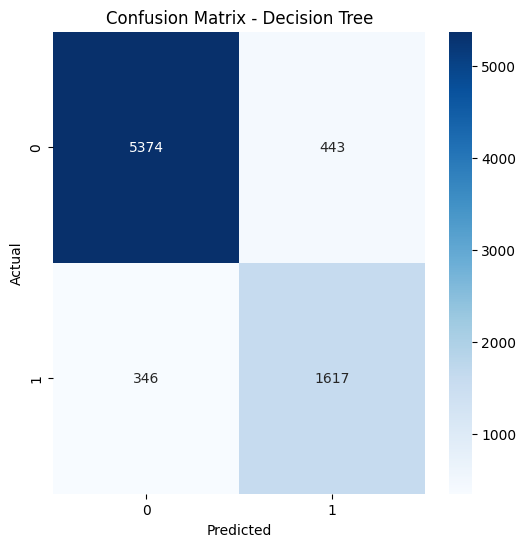


Random Forest Evaluation:
PR AUC: 0.5925
ROC AUC: 0.7885

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      5968
           1       0.70      0.33      0.44      1927

    accuracy                           0.80      7895
   macro avg       0.76      0.64      0.66      7895
weighted avg       0.79      0.80      0.77      7895



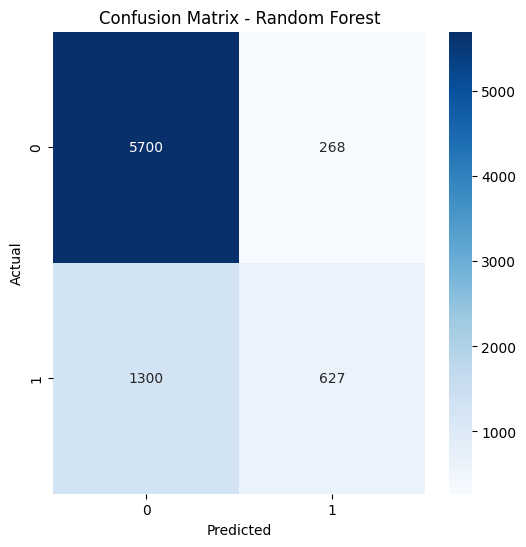


Gradient Boosted Trees Evaluation:
PR AUC: 0.5787
ROC AUC: 0.7826

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      5939
           1       0.69      0.31      0.43      1952

    accuracy                           0.80      7891
   macro avg       0.75      0.63      0.65      7891
weighted avg       0.78      0.80      0.76      7891



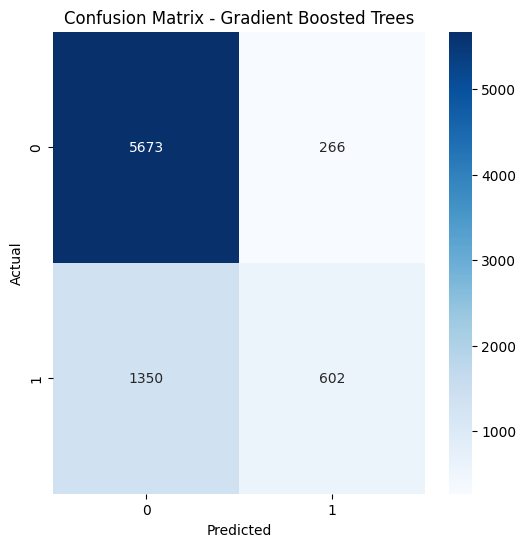

In [56]:
def evaluate_model(predictions, model_name):
    evaluator_pr = BinaryClassificationEvaluator(labelCol="is_fraud",
                                              metricName="areaUnderPR")
    evaluator_roc = BinaryClassificationEvaluator(labelCol="is_fraud",
                                               metricName="areaUnderROC")

    pr = evaluator_pr.evaluate(predictions)
    roc = evaluator_roc.evaluate(predictions)

    # Конвертация в pandas для sklearn метрик
    pred_pandas = predictions.select(["is_fraud", "prediction"]).toPandas()

    print(f"\n{model_name} Evaluation:")
    print(f"PR AUC: {pr:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(pred_pandas["is_fraud"], pred_pandas["prediction"]))

    # Матрица ошибок
    cm = confusion_matrix(pred_pandas["is_fraud"], pred_pandas["prediction"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Оценка всех моделей
evaluate_model(predictions_dt, "Decision Tree")
evaluate_model(predictions_rf, "Random Forest")
evaluate_model(predictions_gbt, "Gradient Boosted Trees")